## <b> Setup <b/>

In [1]:
from utils.initialization import *
from utils.tokenizer import *
from utils.dataset_pipeline import *
from utils.servitization import *
from utils.visualization import *
from models.transformer_bert import *

2021-11-14 17:55:29.558851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-14 17:55:29.558878: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Directory /data exists.
Directory /data/Model_Tensorflow exists.
Directory /data/Model_Pytorch exists.
Directory /data/Text_Tokenizer/vocab exists.
Directory /data/Text_Tokenizer/trained exists.
Directory /data/Text_Sentimentor/dataset exists.
Directory /data/Text_Sentimentor/datatf exists.
Directory /data/Text_Sentimentor/model/savedmodels exists.
Directory /data/Text_Sentimentor/model/checkpoints exists.
Directory /data/Text_Sentimentor/model/logs exists.
Directory /data/Text_Sentimentor/tmp exists.


2021-11-14 17:55:31.725865: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-14 17:55:31.725890: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-14 17:55:31.725910: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2021-11-14 17:55:31.773253: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
### Tokenization Method

### Language Pair

lang_pair = ('en', '')
lang_prefix = f"{lang_pair[0].upper()}_"
inp_lang, tar_lang = lang_pair

### Preprocessor

text_preprocessors = {'inp':en_preprocess, 'tar':None}

### Global Variables

MAX_LENGTHS = {'inp':256, 'tar':None}

In [3]:
### Definition of Bert Model

bert_names = {'inp':BERT_NAMES[inp_lang]['bert'][0],
              'tar':None}
cache_dirs = {'inp':os.path.join(DIR_MODELTORCH, bert_names['inp']),
              'tar':None}

print(f"Using Pretrained Bert Model: {bert_names}")
print(f"Cache Directory of Model: {cache_dirs}")
print(f"\nMax Length of Text: {MAX_LENGTHS}")

Using Pretrained Bert Model: {'inp': 'bert-base-uncased', 'tar': None}
Cache Directory of Model: {'inp': '/data/Model_Pytorch/bert-base-uncased', 'tar': None}

Max Length of Text: {'inp': 256, 'tar': None}


## <b> 1. Download Dataset <b/>
#### <i> IMDB Dataset <i/>

In [4]:
### Download the dataset and record the path

url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url, untar=True, cache_dir=DIR_DATA, cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(dataset_dir, 'train', 'unsup')
shutil.rmtree(remove_dir)

In [5]:
def read_sentiment_dataset(data_dir, label_dict, preprocessor=None):
    data_dir = pathlib.Path(data_dir)
    
    texts, labels = [], []
    for label_dir in label_dict.keys():
        for text_file in (data_dir/label_dir).iterdir():
            texts.append(text_file.read_text())
            labels.append(label_dict[label_dir])

    if preprocessor:
        texts = preprocessor(texts, py_function=True)
    return texts, labels

### Dataset loading & preprocessing

label_dict = {'pos':1, 'neg':0}
train_texts, train_labels = read_sentiment_dataset(os.path.join(dataset_dir, 'train'), label_dict, text_preprocessors['inp'])
test_texts, test_labels = read_sentiment_dataset(os.path.join(dataset_dir, 'test'), label_dict, text_preprocessors['inp'])

### Data splitting

n_keep = 0.1
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_texts, train_labels, 
                                                                        test_size=n_keep, random_state=SEED)

num_samples = len(train_labels)
num_classes = len(set(train_labels))

### Demo

for name, data in zip(['Training', 'Validation', 'Testing'], [train_texts, valid_texts, test_texts]):
    print(f"Number of {name} Data :", len(data))
    
for text, label in zip(train_texts[:5], train_labels):
    print(f'\nReview: {text}')
    print(f'\nLabel : {label}')
    print('\n', '=' * 50)

Number of Training Data : 22500
Number of Validation Data : 2500
Number of Testing Data : 25000

Review: tv does influence society...just look at the surge in popularity of cappucino shops after this shallow little piece of work debuted. besides, real people who look as good as these people do don't have any problems. besides, does anyone really believe that these people can afford to live in a nice manhattan loft considering what they do for a living? nbc just loves to insult the viewer's intelligence, even if they're just around gump's level. i know a person who makes $100,000 a year as a web designer and lives in a tiny one-bedroom apartment in manhattan that costs $2200 a month in rent. i'd like to see a show called phriends, where it's six ugly nobodies in dead-end jobs, living in a crummy neighborhood where sirens constantly wail and someone gets mugged every week...and then the landlord jacks up the rent. now that i would watch.

Label : 0


Review: beyond the fact crazy people 

## <b> 2. Setup Tokenizer & Dataset Pipeline <b/>

In [6]:
tokenizers = tf.Module()
tokenizers.inp = AutoTokenizer.from_pretrained(bert_names['inp'], cache_dir=cache_dirs['inp'], do_lower_case=True)

### Parameters

tokenizer_params = {
    'inp':{'add_special_tokens':True, 'padding':True, 'truncation':True, 'max_length':MAX_LENGTHS['inp'], 
           'return_attention_mask':True, 'return_token_type_ids':False},
    'tar':None
}

### Vocab Sizes

inp_vocab_size = tokenizers.inp.vocab_size

print(f'{inp_lang} Vocabulary Size :', inp_vocab_size)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

en Vocabulary Size : 30522


In [7]:
### Bert Tokenization: can only accept str, List[str] or List[List[str]]

train_encodings = dict(tokenizers.inp(train_texts, **tokenizer_params['inp']))
valid_encodings = dict(tokenizers.inp(valid_texts, **tokenizer_params['inp']))
test_encodings = dict(tokenizers.inp(test_texts, **tokenizer_params['inp']))

del train_texts, valid_texts, test_texts

### Tensorflow Dataset: the amount of data is small so using from_tensor_slices is enough

train_dataset = tf.data.Dataset.from_tensor_slices(((train_encodings['input_ids'], train_encodings['attention_mask']), train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices(((valid_encodings['input_ids'], valid_encodings['attention_mask']), valid_labels))
test_dataset = tf.data.Dataset.from_tensor_slices(((test_encodings['input_ids'], test_encodings['attention_mask']), test_labels))

In [8]:
BUFFER_SIZE = 2**13
BATCH_SIZE = 64

train_batches = make_batches(train_dataset, BATCH_SIZE, BUFFER_SIZE)
valid_batches = make_batches(valid_dataset, BATCH_SIZE)
test_batches = make_batches(test_dataset, BATCH_SIZE, cache=False)

for demo in test_batches.take(1):
    print(demo)

((<tf.Tensor: shape=(64, 256), dtype=int32, numpy=
array([[  101,  2043,  2023, ...,     0,     0,     0],
       [  101,  2009,  1055, ...,     0,     0,     0],
       [  101,  7714,  1010, ...,     0,     0,     0],
       ...,
       [  101,  1045,  2074, ...,     0,     0,     0],
       [  101,  1000, 12801, ...,     0,     0,     0],
       [  101,  2009,  1005, ...,  2023,  2143,   102]], dtype=int32)>, <tf.Tensor: shape=(64, 256), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>), <tf.Tensor: shape=(64,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)>)


## <b> 3. Configure Training <b/>

### <b> Hyperparameters <b/>

In [9]:
### Configure pretrained model

configs = {'inp':AutoConfig.from_pretrained(bert_names['inp'], cache_dir=cache_dirs['inp']),
           'tar':None}
pprint(configs)

### Configure training process

EPOCHS = 100
EARLYSTOP = 5

init_lr = 3e-5

### Configure downstream model structure ( Mark the unused hyperparameters )

num_layers = 1
num_projection_layers = 1
#embed_pos = True
embed_dim = 256
dense_dim = 512
num_heads = 8
dropout = 0.2
activation, activation_name = tf.nn.gelu, 'gelu'

nn_units = 64
all_tune = False
use_lstm = False

### Other configuration

#teacher = 100

{'inp': BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}
,
 'tar': None}


### <b> Loss & Metrics & Optimizer <b/>

In [10]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy_function = tf.keras.metrics.BinaryAccuracy()

metrics = [accuracy_function] 

In [11]:
steps_per_epoch = num_samples//BATCH_SIZE+1
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(0.1*num_train_steps)

optimizer = official.nlp.optimization.create_optimizer(init_lr=init_lr,
                                                       num_train_steps=num_train_steps,
                                                       num_warmup_steps=num_warmup_steps,
                                                       optimizer_type='adamw')
print(f'warmup_steps: {num_warmup_steps}')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


warmup_steps: 3520


### <b> Model <b/>

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


EN_TransformerEncoder_bert-base-uncased
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
tf_bert_model_2 (TFBertModel)   TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
embedding_projector_2 (Embeddin (None, None, 256)   

None

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


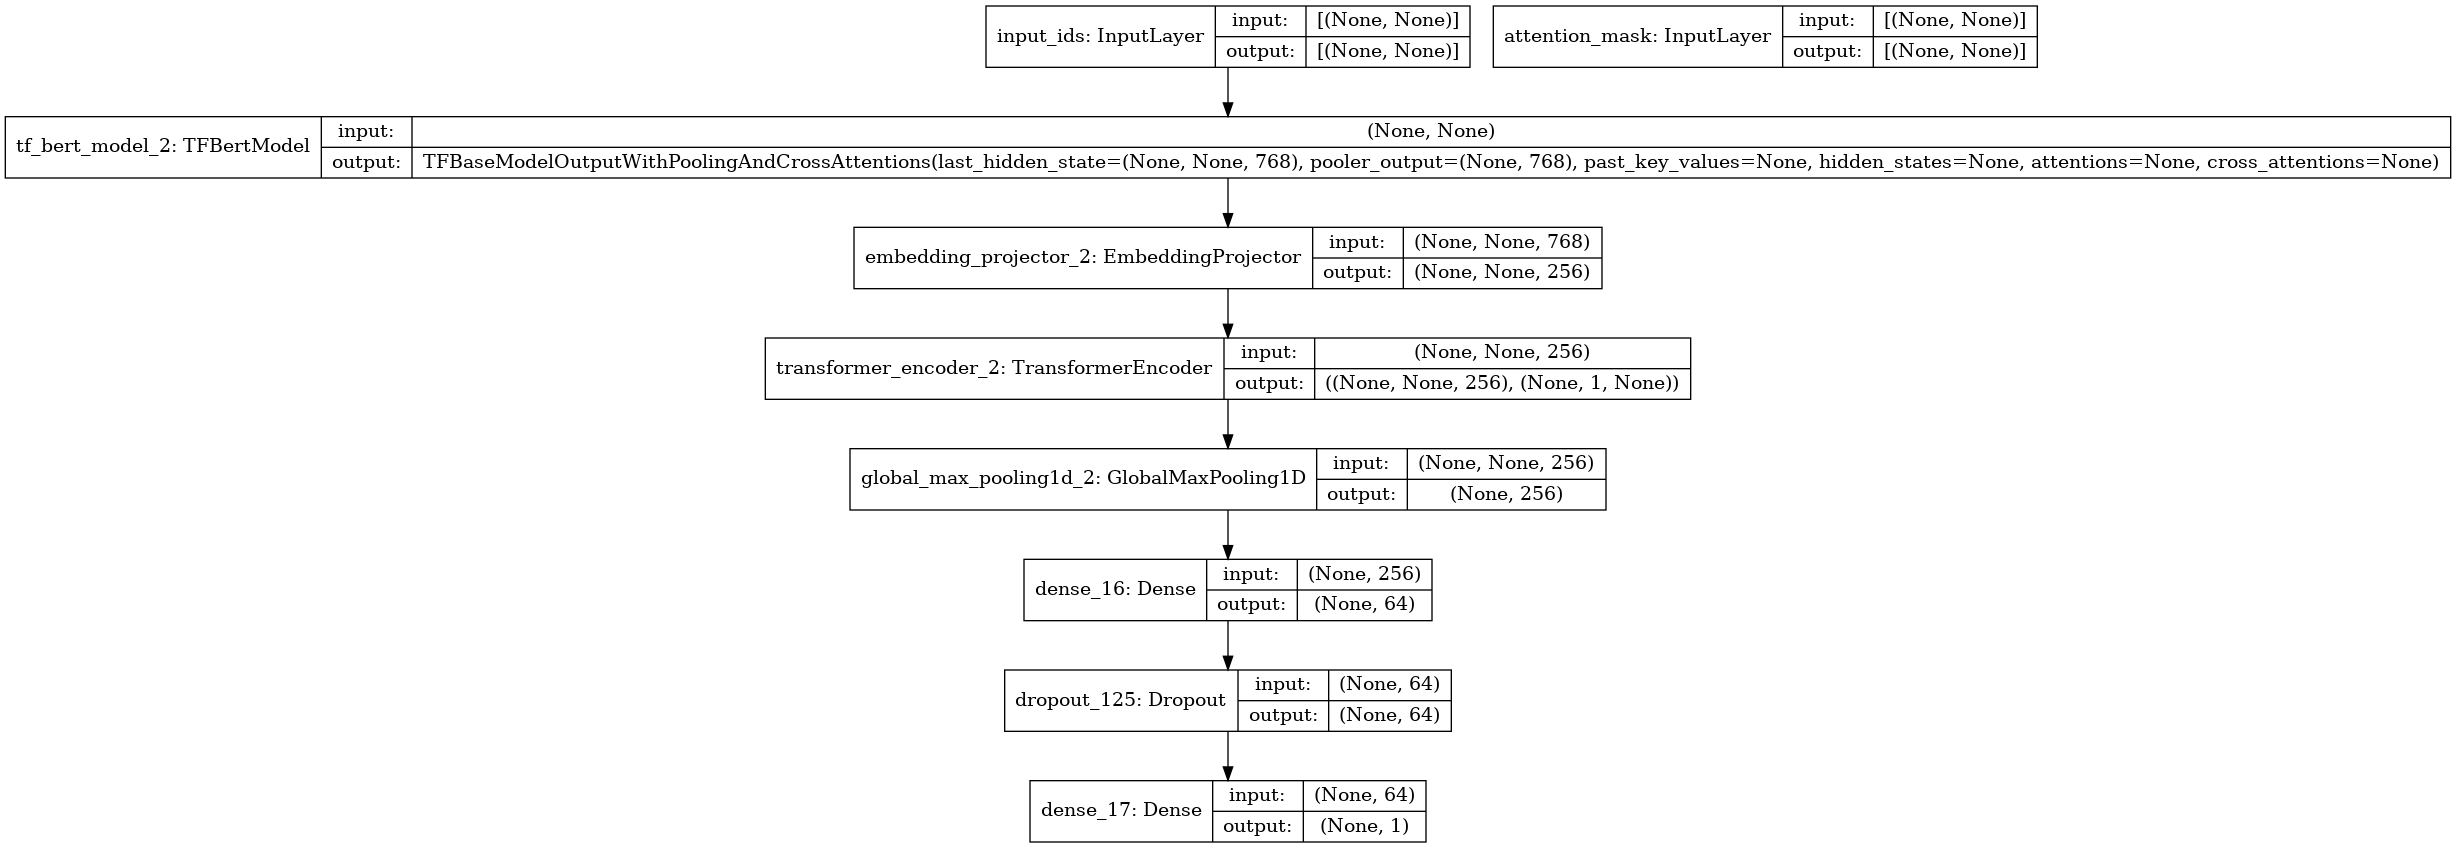

In [15]:
# Plot the model
model_name = lang_prefix+f"TransformerEncoder{'BiLSTM' if use_lstm else ''}_{bert_names['inp']}"
model = BertTransformerEncoder(bert_names=bert_names, 
                               configs=configs, 
                               cache_dirs=cache_dirs, 
                               all_tune=all_tune, 
                               num_projection_layers=num_projection_layers, 
                               use_lstm=use_lstm, 
                               nn_units=nn_units, 
                               num_layers=num_layers, 
                               embed_dim=embed_dim, 
                               num_heads=num_heads, 
                               num_classes=num_classes,
                               dense_dim=dense_dim, 
                               activation=activation, 
                               dropout=dropout)

print(model_name)
display(model.build_graph().summary())
display(tf.keras.utils.plot_model(model.build_graph(), show_shapes=True, expand_nested=True))

## <b> 4. Training and checkpointing <b/>

### <b> Checkpoint <b/>

In [16]:
# 方便比較不同實驗/ 不同超參數設定的結果
run_id  = f"{num_layers}layers_{num_projection_layers}projlayers_{nn_units}nnunits_{num_heads}heads_{embed_dim}embedding_{dense_dim}hidden"
run_id += f"_{dropout}dropout_{activation_name}_{num_warmup_steps}warmup_{optimizer._name}_{'all' if all_tune else 'part'}finetune"
run_id += f"_{BATCH_SIZE}batchsize_{BUFFER_SIZE}shuffle_{num_samples}samples"
print('run_id:', run_id, '\n')

# 設定存檔路徑
checkpoint_path = os.path.join(DIR_CHECKPOINT, model_name+'_'+run_id)
log_dir = os.path.join(DIR_LOG, model_name+'_'+run_id)

# 設定回調函數
es_metric = 'val_loss'

checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor=es_metric, save_weights_only=True, save_best_only=True, verbose=1, filepath=checkpoint_path)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor=es_metric, patience=EARLYSTOP, restore_best_weights=True, verbose=1)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

callbacks = [tensorboard, checkpoint, earlystopping]

# 回覆存檔點
try:
    model.load_weights(checkpoint_path)
    print(f'Restore the checkpoint at {checkpoint_path}')
except:
    print("There is no existed checkpoint ... Start from the beginning.\n")

run_id: 1layers_1projlayers_64nnunits_8heads_256embedding_512hidden_0.2dropout_gelu_3520warmup_AdamWeightDecay_partfinetune_64batchsize_8192shuffle_22500samples 



2021-11-14 17:57:30.940385: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-14 17:57:30.940429: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-14 17:57:30.940610: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Restore the checkpoint at /data/Text_Sentimentor/model/checkpoints/EN_TransformerEncoder_bert-base-uncased_1layers_1projlayers_64nnunits_8heads_256embedding_512hidden_0.2dropout_gelu_3520warmup_AdamWeightDecay_partfinetune_64batchsize_8192shuffle_22500samples


### <b> Training <b/>

In [ ]:
%%time

model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
history = model.fit(train_batches, validation_data=valid_batches, 
                    epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=callbacks)

Epoch 1/100


2021-11-14 17:57:48.952686: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


  1/352 [..............................] - ETA: 1:59:50 - loss: 0.3575 - binary_accuracy: 0.8125

2021-11-14 17:58:03.275087: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-14 17:58:03.275125: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/352 [..............................] - ETA: 1:20:04 - loss: 0.4424 - binary_accuracy: 0.8125

2021-11-14 17:58:16.740105: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-14 17:58:16.752560: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-14 17:58:16.763296: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /data/Text_Sentimentor/model/logs/EN_TransformerEncoder_bert-base-uncased_1layers_1projlayers_64nnunits_8heads_256embedding_512hidden_0.2dropout_gelu_3520warmup_AdamWeightDecay_partfinetune_64batchsize_8192shuffle_22500samples/train/plugins/profile/2021_11_14_17_58_16

2021-11-14 17:58:16.771643: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /data/Text_Sentimentor/model/logs/EN_TransformerEncoder_bert-base-uncased_1layers_1projlayers_64nnunits_8heads_256embedding_512hidden_0.2dropout_gelu_3520warmup_AdamWeightDecay_partfinetune_64batchsize_8192shuffle_22500samples/train/plugins/profile/2021_11_14_1

352/352 [==============================] - 5300s 15s/step - loss: 0.3125 - binary_accuracy: 0.8641 - val_loss: 0.2733 - val_binary_accuracy: 0.8804

Epoch 00001: val_loss improved from inf to 0.27326, saving model to /data/Text_Sentimentor/model/checkpoints/EN_TransformerEncoder_bert-base-uncased_1layers_1projlayers_64nnunits_8heads_256embedding_512hidden_0.2dropout_gelu_3520warmup_AdamWeightDecay_partfinetune_64batchsize_8192shuffle_22500samples
Epoch 2/100
352/352 [==============================] - 5309s 15s/step - loss: 0.2942 - binary_accuracy: 0.8706 - val_loss: 0.2660 - val_binary_accuracy: 0.8796

Epoch 00002: val_loss improved from 0.27326 to 0.26596, saving model to /data/Text_Sentimentor/model/checkpoints/EN_TransformerEncoder_bert-base-uncased_1layers_1projlayers_64nnunits_8heads_256embedding_512hidden_0.2dropout_gelu_3520warmup_AdamWeightDecay_partfinetune_64batchsize_8192shuffle_22500samples
Epoch 3/100
352/352 [==============================] - 5120s 15s/step - loss: 0.28

### <b> Evaluation <b/>

In [ ]:
%%time

loss, accuracy = model.evaluate(test_batches)

score = f"accuracy-{accuracy:.6f}-{dataset_dir[dataset_dir.rfind('/')+1:]}"
score

  6/391 [..............................] - ETA: 1:09:07 - loss: 0.3480 - binary_accuracy: 0.7995

## <b> 5. Model Export & Pipeline Build <b/>

In [49]:
class HF2TFModelExporter(tf.Module):
    """ 
    Save the fine-tuned Hugging Face model with detail information, 
    and should be modified based on the model's inputs.    
    """
    def __init__(self, model, bert_names, config_detail, num_classes, inp_lang='', tar_lang=''):
        self.model = model
        self.num_classes = num_classes
        self.config_detail = tf.Variable(config_detail)
        
        self.inp_bert = tf.Variable(bert_names['inp'] or '')        
        self.tar_bert = tf.Variable(bert_names['tar'] or '')        
        self.inp_lang = tf.Variable(inp_lang)
        self.tar_lang = tf.Variable(tar_lang)     

    # Notice: the input should be encoded as token_ids and masks, 
    # and the signature need to be adjusted based on the number of masks
    @tf.function(input_signature=[[tf.TensorSpec(shape=[None, None], dtype=tf.int32),
                                   tf.TensorSpec(shape=[None, None], dtype=tf.int32)]])
    def __call__(self, inputs, return_prob=True):        
        outputs = self.model(inputs, training=False)
        
        # Multiclass Problem
        if self.num_classes <= 2:
            outputs = tf.nn.sigmoid(outputs)
        else:
            outputs = tf.nn.softmax(outputs)
            if not return_prob:
                outputs = tf.math.argmax(outputs, axis=-1) + 1

        return outputs

In [74]:
### Create and save the predictor

config_detail = f"{model_name}_{score}_{run_id}"
predictor = HF2TFModelExporter(model, bert_names, config_detail=config_detail, num_classes=num_classes, inp_lang=inp_lang)
predictor_dir = os.path.join(DIR_MODEL, f"{model_name}_{score}")
tf.saved_model.save(predictor, export_dir=predictor_dir)

### Reload the pipeline to verify the result

model_dir = predictor_dir
pretrain_dir = DIR_MODELTORCH
pipeline = HF2TFClassifierPipeline(model_dir, pretrain_dir, text_preprocessors, max_length=MAX_LENGTHS['inp'])

## <b> 6. Run Inference <b/>

In [75]:
sentences = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...',
    'this is a bad test', 
    'and happy one is here to be classified',
    'I broke up with my...cat, help me :(:(:(',
    'movie data seems to be not enough',
    'it is definitely not bad'
]

results = pipeline(sentences)
results_for_printing = [f"Input: {sentences[n]:<50} => score: {results[n][0]:.6f}"
                        for n, text in enumerate(sentences)]

print(*results_for_printing, sep='\n')

Input: this is such an amazing movie!                     => score: 0.198779
Input: The movie was great!                               => score: 0.394043
Input: The movie was meh.                                 => score: 0.277968
Input: The movie was okish.                               => score: 0.264516
Input: The movie was terrible...                          => score: 0.172645
Input: this is a bad test                                 => score: 0.264395
Input: and happy one is here to be classified             => score: 0.445607
Input: I broke up with my...cat, help me :(:(:(           => score: 0.117212
Input: movie data seems to be not enough                  => score: 0.223223
Input: it is definitely not bad                           => score: 0.326945
